# Bayesian t-tests

In this quick tutorial we illustrate how to use posterior samples to perform Bayesian hypothesis testing. 


In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import hssm

## Example 1: Separate models

### Simulate Data

We will simulate a simple dataset that contains two conditions. 

In [2]:
# Condition 1
condition_1 = hssm.simulate_data(
    model="ddm", theta=dict(v=0.5, a=1.5, z=0.5, t=0.1), size=500
)

# Condition 2
condition_2 = hssm.simulate_data(
    model="ddm", theta=dict(v=1.0, a=1.5, z=0.5, t=0.1), size=500
)

### Specify Models

We will fit two separate models to the data.

In [3]:
# Model 1
m1 = hssm.HSSM(model="ddm", data=condition_1)

m1.sample(sampler="mcmc", tune=500, draws=500)

# Model 2
m2 = hssm.HSSM(model="ddm", data=condition_2)

m2.sample(sampler="mcmc", tune=500, draws=500)

Model initialized successfully.
Using default initvals. 



Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.12/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
100%|██████████| 2000/2000 [00:00<00:00, 5167.00it/s]


Model initialized successfully.
Using default initvals. 



Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.12/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
100%|██████████| 2000/2000 [00:00<00:00, 5310.53it/s]


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Bayesian t-test

Now, let's ask the (informed) question: 

Is the `v` parameter higher in condition 1 than condition 2?

The beauty of the Bayesian approach is that this questions boils down to simple counting. 

Reformulating the question: Are the `v` samples of my posterior for condition 1 higher than the samples of my posterior for condition 2?

Let's check for that, we have everything we need in our posterior samples!

In [4]:
# Percent of posterior samples
print(
    f"p(v_1 > v_2) = {np.mean(m1.traces.posterior['v'].values > m2.traces.posterior['v'].values)}"
)

p(v_1 > v_2) = 0.0


Looks like our inference indicates that there is a $0\%$ chance for `v` parameter of condition 1 to be higher than the `v` parameter of condition 2.

### Plotting

We can also plot the posterior samples to get a sense of the uncertainty.

Text(0.5, 0, 'v')

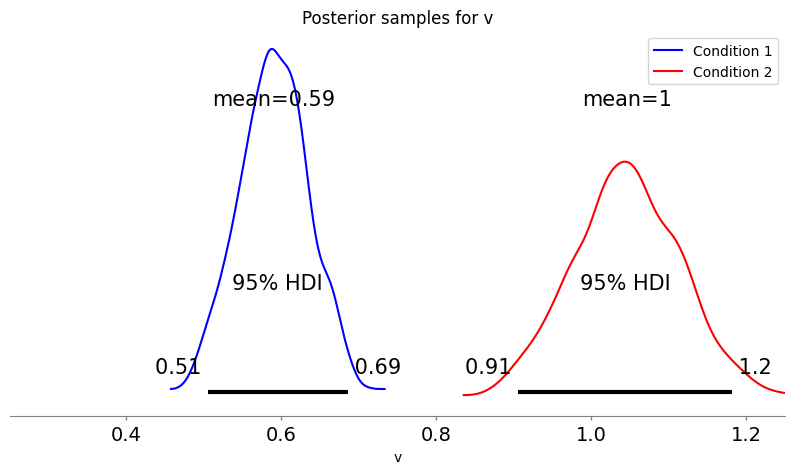

In [5]:
# Specify a plot with one row and two columns
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Plot the posterior samples for condition 1
az.plot_posterior(
    m1.traces.posterior, var_names="v", ax=ax, color="blue", hdi_prob=0.95
)

# Plot the posterior samples for condition 2
az.plot_posterior(m2.traces.posterior, var_names="v", ax=ax, color="red", hdi_prob=0.95)

# Set x-axis limit
ax.set_xlim(0.25, 1.25)

# Create proxy artists for the legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color="blue", label="Condition 1"),
    Line2D([0], [0], color="red", label="Condition 2"),
]

# Add a legend
ax.legend(handles=legend_elements)

# Add a title
ax.set_title("Posterior samples for v")

# Add a x-axis label
ax.set_xlabel("v")

A glance a these posteriors visually corroborates our simple counting analysis. The two posteriors for `v` are clearly separated.

To appreciate the difference, let us also plot the posteriors of the respective `a` parameters.

Text(0.5, 0, 'v')

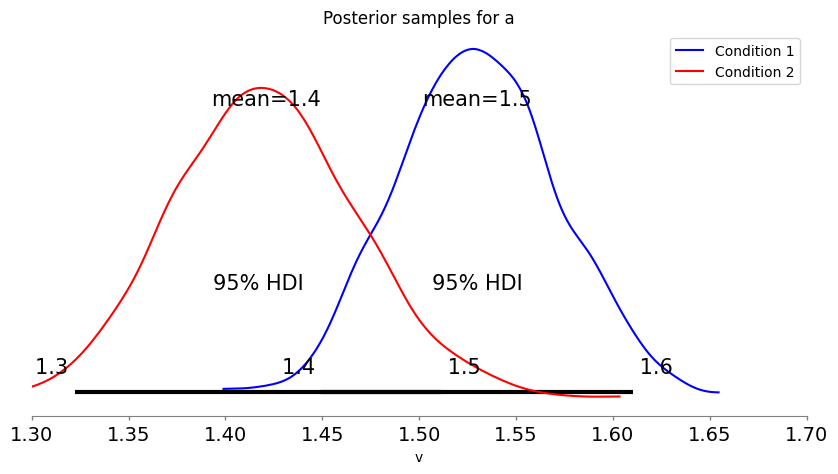

In [6]:
# Specify a plot with one row and two columns
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Plot the posterior samples for condition 1
az.plot_posterior(
    m1.traces.posterior, var_names="a", ax=ax, color="blue", hdi_prob=0.95
)

# Plot the posterior samples for condition 2
az.plot_posterior(m2.traces.posterior, var_names="a", ax=ax, color="red", hdi_prob=0.95)

# Set x-axis limit
ax.set_xlim(1.3, 1.7)

# Create proxy artists for the legend
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color="blue", label="Condition 1"),
    Line2D([0], [0], color="red", label="Condition 2"),
]

# Add a legend
ax.legend(handles=legend_elements)

# Add a title
ax.set_title("Posterior samples for a")

# Add a x-axis label
ax.set_xlabel("v")

and correspondingly,

In [7]:
print(
    f"p(a_1 > a_2) = {np.mean(m1.traces.posterior['a'].values > m2.traces.posterior['a'].values)}"
)

p(a_1 > a_2) = 0.956


## Example 2: Combined Model

In [8]:
condition_1["condition"] = "C1"
condition_2["condition"] = "C2"

data = pd.concat([condition_1, condition_2]).reset_index(drop=True)

In [9]:
m_combined = hssm.HSSM(
    model="ddm",
    data=data,
    include=[
        {
            "name": "v",
            "formula": "v ~ 1 + condition",
        }
    ],
)

idata_combined = m_combined.sample(sampler="mcmc", tune=500, draws=500)

Model initialized successfully.
Using default initvals. 



Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, a, t, v_Intercept, v_condition]


Output()

Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 13 seconds.
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/.venv/lib/python3.12/site-packages/pymc/pytensorf.py:958: FutureWarning: compile_pymc was renamed to compile. Old name will be removed in a future release of PyMC
  warnings.warn(
100%|██████████| 2000/2000 [00:00<00:00, 2495.89it/s]


Note, now we don't have two distinct `idata` objects, but instead we have a single `idata` object with a posterior for `v_condition`. Let's take a closer look.

In [10]:
m_combined.traces.posterior

<xarray.Dataset> Size: 84kB
Dimensions:          (chain: 4, draw: 500, v_condition_dim: 1)
Coordinates:
  * chain            (chain) int64 32B 0 1 2 3
  * draw             (draw) int64 4kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * v_condition_dim  (v_condition_dim) <U2 8B 'C2'
Data variables:
    v_condition      (chain, draw, v_condition_dim) float64 16kB 0.59 ... 0.5945
    z                (chain, draw) float64 16kB 0.4765 0.4883 ... 0.4708 0.4863
    v_Intercept      (chain, draw) float64 16kB 0.5697 0.5411 ... 0.643 0.5514
    t                (chain, draw) float64 16kB 0.1194 0.09772 ... 0.09983
    a                (chain, draw) float64 16kB 1.505 1.481 1.471 ... 1.453 1.51
Attributes:
    created_at:                  2025-07-13T13:15:02.703723+00:00
    arviz_version:               0.21.0
    inference_library:           pymc
    inference_library_version:   5.21.1
    sampling_time:               12.807016849517822
    tuning_steps:                500
    modeling_interface:          bambi
    modeling_interface_version:  0.15.0

Under the hood, Bambi created a model with a dummy variable for the `C2` condition (the `C1` condition represents the *Intercept*).

So what do we need to test here...

We still ask the same question: Is the `v_condition[C2]` posterior higher than the `v_condition[C1]` posterior?

But now we only need to check if our `v_condition[C2]` variable is above `0`, since it represents the *offset* from the *Intercept* directly.

Let's check:

In [11]:
print(
    f"p(v_condition[C2] > v_condition[C1]) = {np.mean(idata_combined.posterior['v_condition'].values > 0)}"
)

p(v_condition[C2] > v_condition[C1]) = 1.0


or visually,

<Axes: title={'center': 'v_condition\nC2'}>

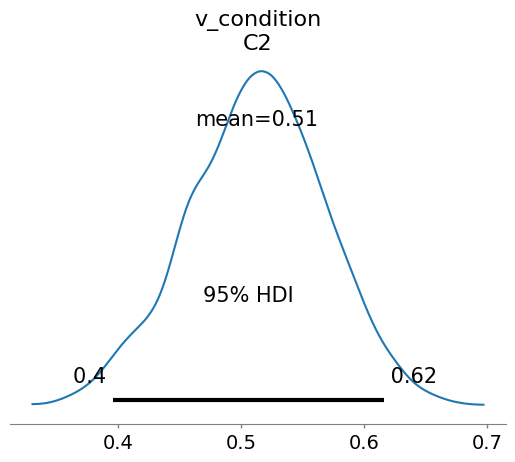

In [12]:
az.plot_posterior(idata_combined.posterior, var_names="v_condition", hdi_prob=0.95)

You can use this approach to test any number of complex statements about your parameters.
There will essentially always be a way to turn your question into a simple comparison of the posterior samples, a simple counting problem.